## 1. Imports

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import torch
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

# Import local modules (assumes notebook is inside `notebooks/`)
import sys
# Ensure repository root is on sys.path so local modules import correctly
sys.path.append(os.path.abspath('..'))
from BattleshipBoardV1 import BattleshipBoardV1
from utils.representation_utils import normalize_tensor
from utils.constants import DEFAULT_ROWS, DEFAULT_COLS
from models.cnn_model import ShipProbCNN, NumpyBoardDataset, train_model, save_model, load_model, predict_board

## 2. Create / Load dataset (simulate synthetic boards)

We generate many random boards, then simulate a simple observation process: we randomly reveal a subset of coordinates as hits/misses. The model input will be the 2-channel tensor (hits, misses); the label will be the occupancy map (ships channel).

In [2]:
def generate_dataset(n_boards=2000, rows=DEFAULT_ROWS, cols=DEFAULT_COLS, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    X = []  # inputs: hits + misses channels
    Y = []  # targets: occupancy channel
    
    for _ in range(n_boards):
        board = BattleshipBoardV1(rows=rows, cols=cols)
        arr = board.to_numpy_array()  # shape (rows, cols, 3)
        # arr[:,:,0] = ships, arr[:,:,1]=hits, arr[:,:,2]=misses (initially all zeros)

        # Simulate revealing some cells: choose a random subset and mark them as hits/misses
        reveal_prob = np.random.uniform()
        revealed = np.random.rand(rows, cols) < reveal_prob

        hits_mask = np.zeros((rows, cols), dtype=float)
        misses_mask = np.zeros((rows, cols), dtype=float)

        # For revealed cells, if ship present -> hit else miss
        hits_mask[revealed & (arr[:, :, 0] == 1.0)] = 1.0
        misses_mask[revealed & (arr[:, :, 0] == 0.0)] = 1.0

        inp = np.stack([hits_mask, misses_mask], axis=-1).astype(np.float32)
        tgt = arr[:, :, 0].astype(np.float32)[..., np.newaxis]  # occupancy channel

        X.append(inp)
        Y.append(tgt)

    X = np.stack(X, axis=0)  # (N, rows, cols, 2)
    Y = np.stack(Y, axis=0)  # (N, rows, cols, 1)

    return X, Y

# Quick generation (smaller for demo)
X, Y = generate_dataset(n_boards=100_000)
print('X shape:', X.shape, 'Y shape:', Y.shape)

X shape: (100000, 10, 10, 2) Y shape: (100000, 10, 10, 1)


## 3. Quick EDA

Sample count: 100000


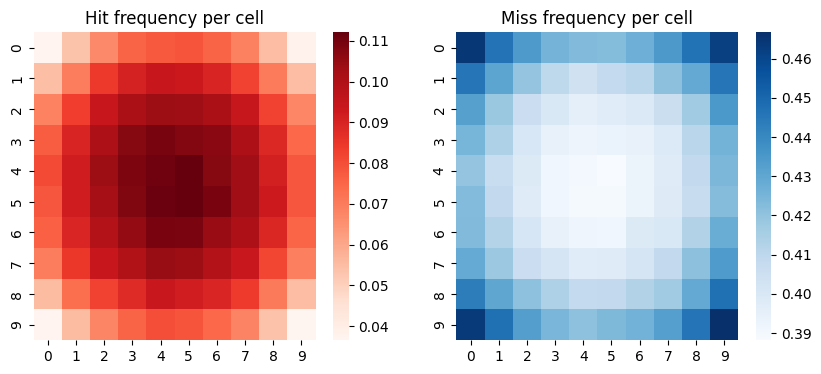

In [3]:
# Sample statistics: fraction of revealed cells per board and global hit-rate
reveal_frac = (X.sum(axis=(1,2,0))>0).mean()
print('Sample count:', X.shape[0])

# Compute hit frequency per cell across dataset (how often a cell was observed as hit)
hit_freq = (X[:, :, :, 0].sum(axis=0)) / X.shape[0]
miss_freq = (X[:, :, :, 1].sum(axis=0)) / X.shape[0]

# Plot hit and miss frequency heatmaps
fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(hit_freq, ax=axs[0], cmap='Reds', cbar=True)
axs[0].set_title('Hit frequency per cell')
sns.heatmap(miss_freq, ax=axs[1], cmap='Blues', cbar=True)
axs[1].set_title('Miss frequency per cell')
plt.show()

## 4. Preprocessing & feature engineering

For this baseline pipeline we flatten the grid and use the raw hit/miss channels as features for scikit-learn models. Advanced features (neighborhood counts, temporal windows) can be added later.

In [4]:
N, R, C, _ = X.shape

# Flatten grid features: two channels per cell -> 2*R*C features
X_flat = X.reshape((N, R*C*2))
# Target: flatten occupancy into binary labels per cell (we will train per-cell classifier by treating each cell as a sample)
Y_flat = Y.reshape((N, R*C))  # shape (N, R*C, 1) -> (N, R*C)

# We'll create a dataset of samples (board_index, cell_index) -> features, label
X_cells = X_flat.reshape(N, R*C, 2).reshape(N*R*C, 2)  # (N*R*C, 2)
# For each cell we use the local hit/miss channels as features.
Y_cells = Y_flat.reshape(N*R*C)  # (N*R*C,) values in {0.0,1.0}

print('Per-cell dataset shapes:', X_cells.shape, Y_cells.shape)

Per-cell dataset shapes: (10000000, 2) (10000000,)


## 5. Train/test split and cross-validation

In [5]:
# Prepare dataset for CNN training
assert TORCH_AVAILABLE, 'PyTorch is required for CNN training. Install torch.'

from torch.utils.data import Subset

# X: (N, H, W, 2), Y: (N, H, W, 1) from generate_dataset
X_inputs = X.astype(np.float32)
Y_targets = Y.squeeze(-1).astype(np.float32)  # (N, H, W)

# optional normalization (inputs are binary 0/1 already)
X_inputs = normalize_tensor(X_inputs) if 'normalize_tensor' in globals() else X_inputs

# Create dataset and simple train/validation split
train_ds = NumpyBoardDataset(X_inputs, Y_targets)
split = int(0.8 * len(train_ds))
train_subset = Subset(train_ds, range(0, split))
test_subset = Subset(train_ds, range(split, len(train_ds)))

## 6. Training

In [6]:
# Instantiate model and train
model = ShipProbCNN(in_channels=2, hidden=32)
model, history = train_model(model, train_subset, test_dataset=test_subset, epochs=10, batch_size=64, lr=1e-3)
print('CNN training complete')

Epoch 1/10 - train_loss: 0.1941 - test_loss: 0.1732
Epoch 2/10 - train_loss: 0.1736 - test_loss: 0.1712
Epoch 3/10 - train_loss: 0.1719 - test_loss: 0.1708
Epoch 4/10 - train_loss: 0.1710 - test_loss: 0.1700
Epoch 5/10 - train_loss: 0.1703 - test_loss: 0.1698
Epoch 6/10 - train_loss: 0.1699 - test_loss: 0.1688
Epoch 7/10 - train_loss: 0.1694 - test_loss: 0.1688
Epoch 8/10 - train_loss: 0.1690 - test_loss: 0.1684
Epoch 9/10 - train_loss: 0.1686 - test_loss: 0.1681
Epoch 10/10 - train_loss: 0.1683 - test_loss: 0.1683
CNN training complete


In [7]:
# Save trained model to disk
os.makedirs('models', exist_ok=True)
save_model(model, 'models/ship_cnn.pt')
print('Model saved to models/ship_cnn.pt')

Model saved to models/ship_cnn.pt


## 7. Visualize predictions on the grid / heatmaps

Here we map per-cell probabilities back to grid shape for a few sample boards.

Model loaded from models/ship_cnn.pt
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu


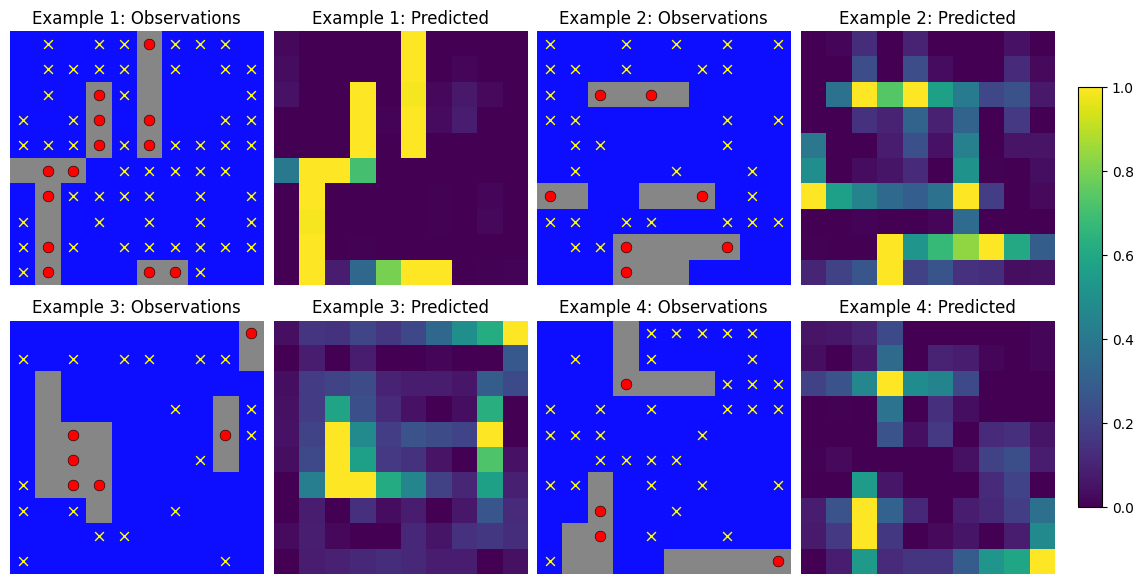

In [10]:
from matplotlib.colors import ListedColormap
def visualize_boards_grid(layout=(4,2), figsize=(6,3)):
    # parse layout
    if isinstance(layout, (tuple, list)) and len(layout) == 2:
        num_examples, examples_per_row = int(layout[0]), int(layout[1])
    elif isinstance(layout, int):
        num_examples, examples_per_row = int(layout), 2
    else:
        raise ValueError('layout must be int or (N,per_row)')
    
    model = load_model('models/ship_cnn.pt', in_channels=2, hidden=32)
    print('Model loaded from models/ship_cnn.pt')

    num_examples = min(num_examples, X.shape[0])

    # layout geometry
    n_rows = (num_examples + examples_per_row - 1)//examples_per_row
    total_cols = examples_per_row * 2
    rows, cols = X.shape[1], X.shape[2]

    # indices to display
    sample_indices = [random.randint(0, X.shape[0]-1) for _ in range(num_examples)]

    # figure setup
    fig_w = figsize[0] * examples_per_row
    fig_h = figsize[1] * n_rows
    fig, axes = plt.subplots(n_rows, total_cols, figsize=(fig_w, fig_h), squeeze=False, gridspec_kw={'wspace':0.04, 'hspace':0.10})
    axes = np.atleast_2d(axes)
    board_cmap = ListedColormap(['blue', 'grey'])
    predict_cmap = 'viridis'

    # plotting loop
    last_im = None
    used_axes = set()
    for i, board_idx in enumerate(sample_indices):
        row_idx = i // examples_per_row
        col_block = (i % examples_per_row) * 2

        true_grid = Y[board_idx].reshape((rows, cols))
        hit_mask = X[board_idx, :, :, 0]
        miss_mask = X[board_idx, :, :, 1]

        inp = np.stack([hit_mask, miss_mask], axis=-1).astype(np.float32)

        probs = predict_board(model, inp)

        ax_obs = axes[row_idx, col_block]
        ax_pred = axes[row_idx, col_block + 1]
        ax_obs.imshow(true_grid, cmap=board_cmap, alpha=0.95, vmin=0, vmax=1, aspect='equal')

        hit_y, hit_x = np.where(hit_mask == 1)
        miss_y, miss_x = np.where(miss_mask == 1)

        ax_obs.scatter(hit_x, hit_y, c='red', marker='o', s=60, edgecolors='black', linewidths=0.4, zorder=3)
        ax_obs.scatter(miss_x, miss_y, c='yellow', marker='x', s=40, linewidths=1.0, zorder=3)
        ax_obs.set_title(f'Example {i+1}: Observations')
        ax_obs.set_axis_off()

        last_im = ax_pred.imshow(probs, cmap=predict_cmap, vmin=0, vmax=1, aspect='equal')
        ax_pred.set_title(f'Example {i+1}: Predicted')
        ax_pred.set_axis_off()

        used_axes.add((row_idx, col_block))
        used_axes.add((row_idx, col_block + 1))

    # turn off unused axes
    for r in range(n_rows):
        for c in range(total_cols):
            if (r, c) not in used_axes: axes[r, c].set_axis_off()

    # colorbar on right
    if last_im is not None:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(last_im, cax=cbar_ax)

    fig.subplots_adjust(left=0.03, right=0.90, top=0.95, bottom=0.03)
    plt.show()

visualize_boards_grid((4,2))